# Digit Recognition - Modern Convolutional Neural Network

Since the original implementation of (LeCun, 1989), significant progress has been made in the field of digit classification. Nowdays, there are relatively leighweight designs that can get **99+% test accuracy** in only a few runs through the training data. The aim of this report is to provide one such **leightweight CNN**, that makes use of these advances to reach maximum possible classification accuracy.  

In [1]:
# Setting path for proper imports 
import sys
import os
sys.path.append(os.path.abspath('..'))

In [23]:
# Importing all Relevant Modules
import torch
import numpy as np
import matplotlib.pyplot as plt
import data.utils as data
import training.train as train
import training.tune as tune
from models.mod_CNN import ModCNN
import random

## Data

Since the goal for this part of the exploration is efficiency and not reproduction of previous implementations, the data used will be the standard 28x28 MNIST Dataset. The training and testing will be done on the original images, and there will be no manual claing or padding.

In [3]:
# fetching the data
(x_train, y_train), (x_test, y_test) = data.get_MNIST()
train_set = data.create_dataset(x_train, y_train)
val_set = data.create_dataset(x_test, y_test)

## Model Architecture & Training - ModCNN

(discuss what is different/better anout this architecture compared to LeNet1989)
talk about bigger moe advanced layers. ReLU activation function. Drouput Layers, Max Pooling vs Avg Pooling, Double fully connected layers, Cross Entropy loss, Adam Optimizer vs SGD


### Architecture 
The model architecture differs significantly from [LeNet1989](reprod.ipynb), featuring significantly more parameters (kernels) and advanced modules. 

![ModCNN Architecture Graph](../img/ModCNNArch.jpeg)

The model consists of **three convolutional layers** and **two pooling layers**, followed by **two fully connected feed-forward layers**, ultimately connecting to the **10 unit output layer**. A key difference in **ModCNN** is the number of filters. The convolutional layers contain 32, 64, and 128 kernels respectively, allowing for a far more **detailed feature extraction**. Another difference is the use of **max pooling** over the previously used **average pooling**, which cause the feature maps to focus on **strongest features**, rather than blending them. The two **fully connected feed-forward layers** transform the extracted features into the 10 unit output. Lastly, the **dropout layer** randomly **zeros** some of the neurons, allowing the model to **generalize** better, rather than "remebering" the training data. 

### Training

Another significant advancement is the improvement of training setup, particularly the loss function and optimizer. While the original implementation was based on **MSE-Loss**, however in recent years **Cross-Entropy-Loss** has become the prevailing choice. The particular advantage is the punishing of **wrong-confident predictions**. Additionally **C-E-Loss** keeps stronger gradients, causing a faster and more stable learning. 

The optimizer is another important choice in the training set up. The original paper used **stochastic gradient descent**, a simpler implementation that generalizes well, but struggles with speed and is more dependent on careful tuning. A more moder approach is the use of **adaptive momentum estimation (ADAM)** which converges fast and needs less hyperparameter tuning. Additionally the **adaptive learning rates** allow parameters to have individual step sizes, ideal for **CNNs** where filters have strongly differing gradient magnitudes. 


In [ ]:
# instantiation and training of model
model = ModCNN()

df = train.train_ModCNN(train_data=train_set, test_data=val_set, model=model, n_epochs=10)

## Model Evaluation

After 10 passes through the training data, the model reaches a **validation accuracy** of **~99.2%** reaching modern standards for the MNIST dataset. In the following plots, gathered data will be visualized to properly evaluate modell performance and training infrastructure. 

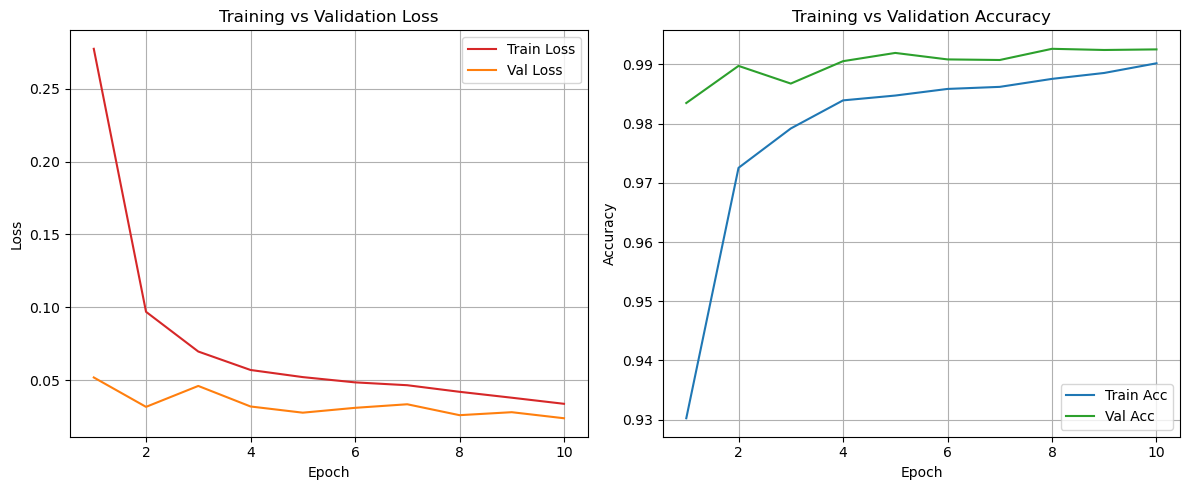

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ---- Left: Loss curves ----
axes[0].plot(df["epoch"], df["train_loss"], label="Train Loss", color="tab:red")
axes[0].plot(df["epoch"], df["val_loss"], label="Val Loss", color="tab:orange")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training vs Validation Loss")
axes[0].legend()
axes[0].grid(True)

# ---- Right: Accuracy curves ----
axes[1].plot(df["epoch"], df["train_acc"], label="Train Acc", color="tab:blue")
axes[1].plot(df["epoch"], df["val_acc"], label="Val Acc", color="tab:green")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training vs Validation Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Loss and Accuracy

**ModCNN** reaches a **Cross Entropy Loss** of under 0.05 on both training and validation set. Furthermore, it reaches an accuracy of **99+%**. A key factor of ModCNN is the speed at which it reaches these benchmark numbers, achieving a validation accuracy of over 99% after only 3 epochs. This model has a **stable learning curve** as can be seen by lack of significant oscilation or divergence.

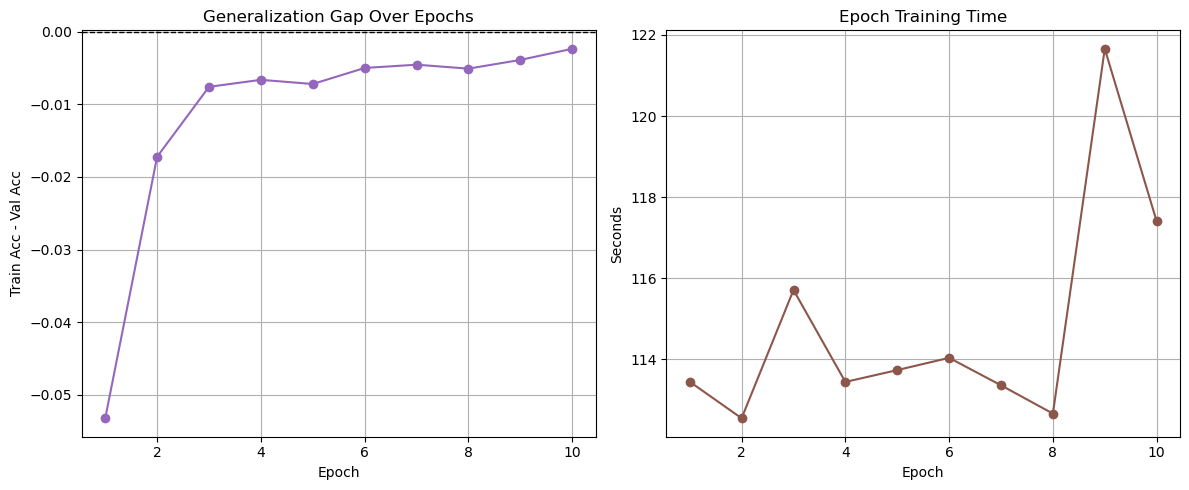

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ---- Left: Generalization Gap ----
axes[0].plot(df["epoch"], df["gen_gap"], marker="o", color="tab:purple")
axes[0].axhline(0, linestyle="--", color="black", linewidth=1)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Acc - Val Acc")
axes[0].set_title("Generalization Gap Over Epochs")
axes[0].grid(True)

# ---- Right: Epoch Time ----
axes[1].plot(df["epoch"], df["epoch_time"], marker="o", color="tab:brown")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Seconds")
axes[1].set_title("Epoch Training Time")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Overfitting and Efficiency

The **generalization gap** ($acc_{train} - acc_{val}$) will again be used to determine whether the model is overfitting. As seen in the plot, the gap reaches **~-1%** after just a couple of epochs, converging to around **-0.5%** This that the model is learning well, and not overfitting the training data. This model also indicates very good generalization through its **negative generalization gap**. This can most likely be attributed to the droput layer at the end of the network.

As seen by the **Epoch Training Time** the model takes a significant amount of time to pass through the data (~115 seconds). This is a great increase from the previous model, that was only taking around 10s per pass. This increase can be attributed to the significant increase of learned parameters in ModCNN. 

## Model Visualization

Here follows a visualization of the **32 learned filters** of the **C1 Layer**. 

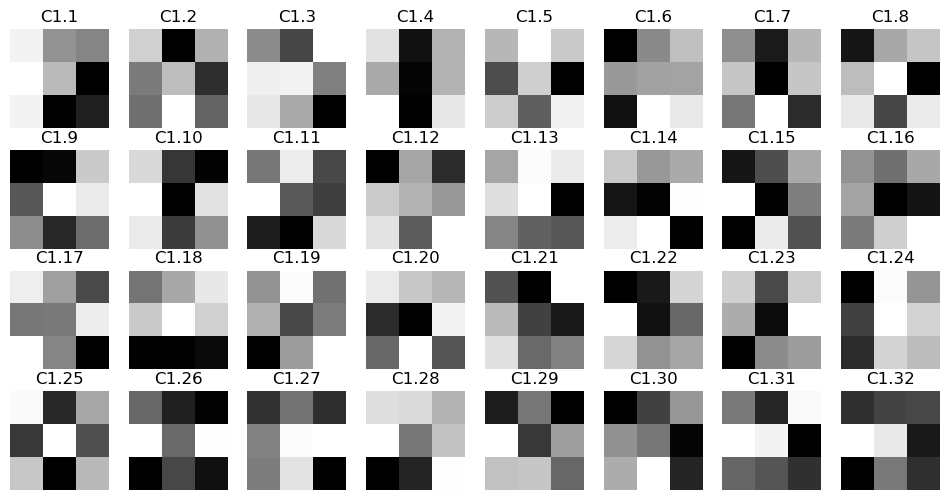

In [8]:
model = torch.load("ModCNN.pt", weights_only=False)
model.eval()

weights = model.C1.weight.data.clone()

fig, axes = plt.subplots(4, 8, figsize=(12, 6))

for i, ax in enumerate(axes.flat, start=1):
    ax.imshow(weights[i-1, 0].cpu(), cmap="gray")  # first channel
    ax.axis("off")
    ax.set_title(f"C1.{i}")  # individual subtitle


plt.show()

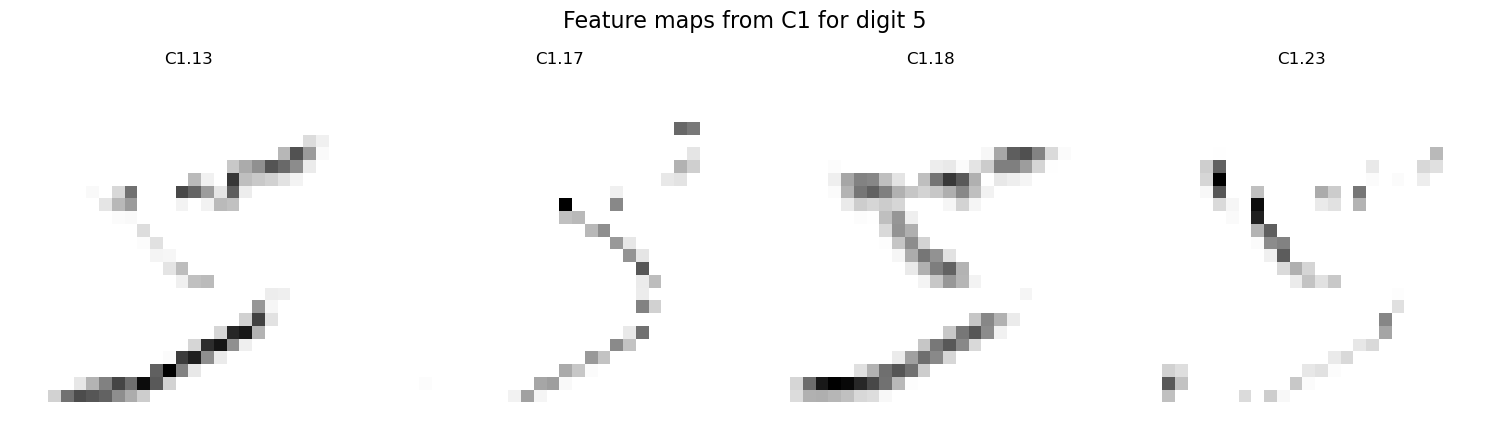

In [20]:
img, label = train_set[0]

img = img.unsqueeze(0)

with torch.no_grad():
    c1_out = torch.nn.functional.relu(model.C1(img))

feature_maps = c1_out.squeeze(0).cpu()

# ---- Plot feature maps ----
num_maps = feature_maps.shape[0]
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

n = sorted([random.randint(0, 31) for _ in range(4)])


for i in range(4):
    axes[i].imshow(feature_maps[n[i]], cmap="gray_r")
    axes[i].axis("off")
    axes[i].set_title(f"C1.{n[i] + 1}")


plt.tight_layout()

plt.suptitle(f"Feature maps from C1 for digit {label}", fontsize=16)
plt.show()

## Finetuning 

After running initial training with the **ADAM Optimizer**, the model can be finetuned using **SGD + Momentum**. The learning rate starts out with 0.01 and is adjusted through **Cosine Annealing LR**, which decays the learning rate along the cosine curve. This has been shown to significantly improve finetuning performance.  

In [ ]:
df = tune.tune_ModCNN(train_data=train_set, test_data=val_set, model=model, n_epochs=15)

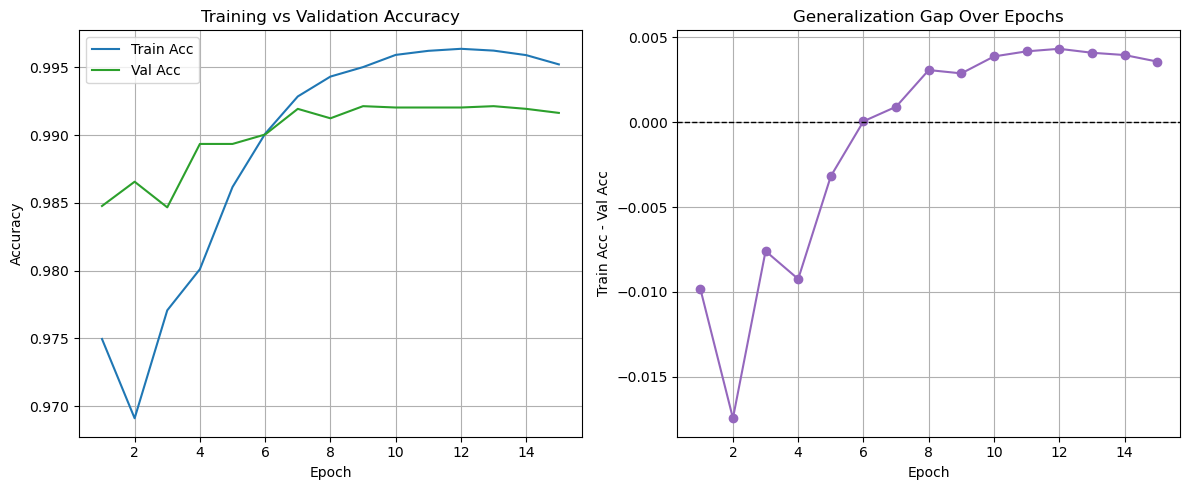

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ---- Right: Gen curves ----
axes[1].plot(df["epoch"], df["gen_gap"], marker="o", color="tab:purple")
axes[1].axhline(0, linestyle="--", color="black", linewidth=1)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Train Acc - Val Acc")
axes[1].set_title("Generalization Gap Over Epochs")
axes[1].grid(True)

# ---- Left: Accuracy curves ----
axes[0].plot(df["epoch"], df["train_acc"], label="Train Acc", color="tab:blue")
axes[0].plot(df["epoch"], df["val_acc"], label="Val Acc", color="tab:green")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy")
axes[0].legend()
axes[0].grid(True)

plt.tight_layout()
plt.show()

After **finetuning** the model, the **validation accuracy** stabilizes at **99.21%**. Particularly interesting is that the model loses is negative generalization gap after the 6th epoch. Yet, the generalization gap stays below **0.5%**, meaning the model is still not overfitting the training set.  

## Conclusion/Outlook

Overall, ModCNN did very well with classifying hadnwritten digits, reaching benchmark standards of **99+%** accuracy and clearly outperforming LeNet1989. While more heavyweight than LeNet1989, the model still trains fairly quickly, with the training and finetuning taking less than **30 minutes** locally on my MacBook. Overall, the finetuning did not cause any major improvements, however it was interesting exploring **SGD + Momentum** and **Cosine Annealing LR**. A future improvement I might consider is some **hyperparameter tuning** by doing a **random search** to find optimal values for **Learning-Rate**, **Dropuout**, and **Batch-Size**. 